In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pymongo as pm
import numpy as np

x = np.linspace(-2, 2, 101)[np.random.RandomState(0).permutation(101)]
y = x ** 3 - 1

### 1.) Insert x and y into the database "tasks", collection "polyfunction" on host "localhost", port "24444", read it out again in sorted order print "x" and plot "y"

In [2]:
port = 24444
host = 'localhost'
connection = pm.MongoClient(port = port, host = host)

entries = []
for i in range(101):
    entries.append({'x': x[i], 'y': y[i]})
connection['tasks']['polyfunction'].insert_many(entries)

[-2.0, -2.0, -1.96, -1.96, -1.92, -1.92, -1.88, -1.88, -1.84, -1.84, -1.8, -1.8, -1.76, -1.76, -1.72, -1.72, -1.68, -1.68, -1.6400000000000001, -1.6400000000000001, -1.6, -1.6, -1.56, -1.56, -1.52, -1.52, -1.48, -1.48, -1.44, -1.44, -1.4, -1.4, -1.3599999999999999, -1.3599999999999999, -1.3199999999999998, -1.3199999999999998, -1.28, -1.28, -1.24, -1.24, -1.2, -1.2, -1.1600000000000001, -1.1600000000000001, -1.12, -1.12, -1.08, -1.08, -1.04, -1.04, -1.0, -1.0, -0.96, -0.96, -0.9199999999999999, -0.9199999999999999, -0.8799999999999999, -0.8799999999999999, -0.8400000000000001, -0.8400000000000001, -0.8, -0.8, -0.76, -0.76, -0.72, -0.72, -0.6799999999999999, -0.6799999999999999, -0.6399999999999999, -0.6399999999999999, -0.5999999999999999, -0.5999999999999999, -0.56, -0.56, -0.52, -0.52, -0.48, -0.48, -0.43999999999999995, -0.43999999999999995, -0.3999999999999999, -0.3999999999999999, -0.3599999999999999, -0.3599999999999999, -0.32000000000000006, -0.32000000000000006, -0.28, -0.28, -

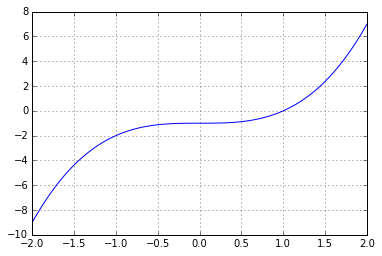

In [3]:
entries = connection['tasks']['polyfunction'].find({'x': {'$exists' : True}}, projection=['x', 'y']).sort([('x',pm.ASCENDING)])
x = [entry['x'] for entry in entries]
print(x)
entries = connection['tasks']['polyfunction'].find({'x': {'$exists' : True}}, projection=['x', 'y']).sort([('x',pm.ASCENDING)])
y = [entry['y'] for entry in entries]
plt.plot(x,y)
plt.grid()

### 2.) Run the script below which trains a MLP for the 10-way MNIST classification task 

In [4]:
import tensorflow as tf
from __future__ import division
from tfutils import base, data, optimizer, utils

# delete exp1
connection['mnist']['simple.files'].delete_many({'exp_id' : 'exp1'})

def mnist_model(inputs, train=True, **kwargs):
    # trainable variables randomly initialized
    with tf.variable_scope("mnist"):
        W1 = tf.get_variable('W1', [784,128], tf.float32, tf.random_normal_initializer(stddev=0.1))
        b1 = tf.get_variable('b1', [128], tf.float32, tf.random_normal_initializer(stddev=0.1))
        W2 = tf.get_variable('W2', [128,32], tf.float32, tf.random_normal_initializer(stddev=0.1))
        b2 = tf.get_variable('b2', [32], tf.float32, tf.random_normal_initializer(stddev=0.1))
        W3 = tf.get_variable('W3', [32,10], tf.float32, tf.random_normal_initializer(stddev=0.1))
        b3 = tf.get_variable('b3', [10], tf.float32, tf.random_normal_initializer(stddev=0.1))
        
        # hidden layers
        h1 = tf.nn.sigmoid(tf.matmul(inputs['images'], W1) + b1, name='hidden1')
        h2 = tf.nn.sigmoid(tf.matmul(h1, W2) + b2, name='hidden2')
        # output
        output = tf.matmul(h2, W3) + b3

    return output, {}

params = {}

params['load_params'] = {
    'do_restore': False}

params['save_params'] = {
    'host': 'localhost',
    'port': 24444,
    'dbname': 'mnist',
    'collname': 'simple',
    'exp_id': 'exp1',
    'save_valid_freq': 200,
    'save_filters_freq': 100,
    'cache_filters_freq': 100}

params['train_params'] = {
    'data_params': {'func': data.MNIST,
                    'batch_size': 256,
                    'group': 'train',
                    'n_threads': 1},
    'queue_params': {'queue_type': 'random',
                     'batch_size': 256},
    'num_steps': 100}

params['model_params'] = {
    'func': mnist_model} 

params['learning_rate_params'] = {
    'learning_rate': 0.5,
    'decay_steps': 500,
    'decay_rate': 0.95,
    'staircase': True}

params['optimizer_params'] = {
    'func': optimizer.ClipOptimizer,
    'optimizer_class': tf.train.MomentumOptimizer,
    'momentum': 0.9,
    'clip': True,
}

params['loss_params'] = {
    'targets': ['labels'],
    'loss_per_case_func': tf.nn.sparse_softmax_cross_entropy_with_logits,
    'agg_func': tf.reduce_mean
}

params['skip_check'] = True

base.train_from_params(**params)

INFO:tfutils:No seed specified for model 0... Defaulting to seed: 0.
INFO:tfutils:No prefix specified for model 0... Defaulting to prefix: model_0.
INFO:tfutils:No devices specified for model 0... Defaulting to gpus: ['/gpu:0'].
INFO:tfutils:thres_loss not specified for model 0... Defaulting thres_loss to: 100.
INFO:tfutils:train_loop not specified for model 0... Using default training loop.
INFO:tfutils:validate_fist not specified for model 0... Defaulting validate_first to: True.
INFO:tfutils:minibatch_size not specified for training data_params... Defaulting minibatch_size to: 256 (identical to the batch size).


Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz


INFO:tfutils:Initialized from scratch first
INFO:tfutils:Training beginning ...
INFO:tfutils:Saving model with path prefix /home/mrowca/.tfutils/localhost:24444/mnist/simple/exp1/checkpoint ... 


mnist/b2/Momentum
global_step
mnist/W1/Momentum
Variable_5
mnist/b3/Momentum
mnist/W3/Momentum
mnist/b1
mnist/b2
mnist/b3
Variable_3
Variable_2
Variable_1
mnist/W2/Momentum
Variable
Variable_4
mnist/b1/Momentum
mnist/W3
mnist/W2
mnist/W1


INFO:tfutils:... done saving with path prefix /home/mrowca/.tfutils/localhost:24444/mnist/simple/exp1/checkpoint-0
INFO:tfutils:Putting filters into <gridfs.GridFS object at 0x7fc3e1dc0750> database
INFO:tfutils:... done putting filters into database.
INFO:tfutils:Step 1 (1045 ms) -- loss: 2.3336, learning_rate: 0.5000
INFO:tfutils:Step 2 (162 ms) -- loss: 2.3157, learning_rate: 0.5000
INFO:tfutils:Step 3 (67 ms) -- loss: 2.2865, learning_rate: 0.5000
INFO:tfutils:Step 4 (7 ms) -- loss: 2.3179, learning_rate: 0.5000
INFO:tfutils:Step 5 (15 ms) -- loss: 2.3315, learning_rate: 0.5000
INFO:tfutils:Step 6 (7 ms) -- loss: 2.2947, learning_rate: 0.5000
INFO:tfutils:Step 7 (60 ms) -- loss: 2.2632, learning_rate: 0.5000
INFO:tfutils:Step 8 (9 ms) -- loss: 2.2829, learning_rate: 0.5000
INFO:tfutils:Step 9 (44 ms) -- loss: 2.2809, learning_rate: 0.5000
INFO:tfutils:Step 10 (127 ms) -- loss: 2.2501, learning_rate: 0.5000
INFO:tfutils:Step 11 (7 ms) -- loss: 2.1887, learning_rate: 0.5000
INFO:tfut

[[ObjectId('59dd49581742f9997ce35a8f'), ObjectId('59dd495c1742f9997ce35a95')]]

### 3.) Now let's load the trained model from the database and test it on the validation set using TFUtils. There are 10,000 examples in the MNIST test set.
### Fill in the blanks marked with EDIT!

In [5]:
def top1_func(inputs, outputs): 
    return {'top1': tf.nn.in_top_k(outputs, inputs['labels'], 1)}

def online_agg(agg_res, res, step):
    """
    Appends the value for each key
    """
    if agg_res is None:
        agg_res = {k: [] for k in res}
    for k, v in res.items():
        agg_res[k].append(v)
    return agg_res

def agg_mean(x):
    return {k: np.mean(v) for k, v in x.items()}

params = {}

params['load_params'] = {
    'host': 'localhost',
    'port': 24444,
    'dbname': 'mnist',
    'collname': 'simple',
    'exp_id': 'exp1',
    'do_restore': True}

params['validation_params'] = {'valid0': {
    'data_params': {'func': data.MNIST,
                    'batch_size': 100,
                    'group': 'test',
                    'n_threads': 1},
    'queue_params': {'queue_type': 'fifo',
                     'batch_size': 100},
    'targets': {'func': top1_func},
    'num_steps': 100,
    'agg_func': agg_mean,
    'online_agg_func': online_agg,}}

params['model_params'] = {
    'func': mnist_model}

params['skip_check'] = True

base.test_from_params(**params)

# Extract record from database
q_val = {'exp_id' : 'exp1', 'validation_results' : {'$exists' : True}, 'validates': {'$exists': True}}
val_steps = connection['mnist']['simple.files'].find(q_val, projection = ['validation_results'])
top1 = [val_steps[i]['validation_results']['valid0']['top1'] 
        for i in range(val_steps.count())]
print(top1)

INFO:tfutils:No seed specified for model 0... Defaulting to seed: 0.
INFO:tfutils:No prefix specified for model 0... Defaulting to prefix: model_0.
INFO:tfutils:No devices specified for model 0... Defaulting to gpus: ['/gpu:0'].
INFO:tfutils:Initialized from scratch first
INFO:tfutils:Loading checkpoint from mnist.simple.files
INFO:tfutils:Cache file found at /home/mrowca/.tfutils/localhost:24444/mnist/simple/exp1/checkpoint-100, using that to load


Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz


INFO:tfutils:Loading checkpoint from mnist.simple.files
INFO:tfutils:Cache file found at /home/mrowca/.tfutils/localhost:24444/mnist/simple/exp1/checkpoint-100, using that to load
INFO:tfutils:Restoring variables from record 59dd495c1742f9997ce35a95 (step 100)...
INFO:tfutils:Saved Vars:
['global_step', 'mnist/W1/Momentum', 'mnist/b3/Momentum', 'mnist/b2', 'mnist/W3/Momentum', 'mnist/b1', 'Variable_5', 'mnist/b3', 'Variable_3', 'mnist/W1', 'Variable_1', 'mnist/W2/Momentum', 'Variable', 'Variable_4', 'mnist/b1/Momentum', 'mnist/W3', 'mnist/W2', 'mnist/b2/Momentum', 'Variable_2']
INFO:tfutils:No variable mapping specified.
INFO:tfutils:Saved shapes:
{'Variable_4': [32, 10], 'global_step': [], 'mnist/W1/Momentum': [784, 128], 'mnist/b3/Momentum': [10], 'mnist/W3/Momentum': [32, 10], 'mnist/b1': [128], 'mnist/b2': [32], 'mnist/b3': [10], 'Variable_3': [32], 'mnist/b2/Momentum': [32], 'Variable_1': [128], 'mnist/W2/Momentum': [128, 32], 'Variable': [784, 128], 'Variable_5': [10], 'mnist/b1/

[0.8934]


### 4.) Execute the script below to load the meta data

In [6]:
#load from tfrecords
import cPickle
import numpy as np
data_path = '/home/mrowca/neural_data.pkl' # CHANGE THIS TO '/datasets/neural_data/neural_data.pkl'
with open(data_path) as f:
    data = cPickle.load(f)
meta = data['meta']
IT_features = data['IT']
meta.dtype.names

('obj',
 'rxz',
 'rxy',
 'ryz',
 'ty',
 'tz',
 's',
 'bg_id',
 'size',
 'var',
 '_id',
 'filename',
 'id',
 'category',
 'rxz_semantic',
 'rxy_semantic',
 'ryz_semantic')

### 5.) Select all files with 'Animals' or 'Cars' with a rotation in the xy-plane of more than 45 degrees and print how many there are:

In [7]:
files = meta[(meta['category'] == 'Cars') & (meta['rxz'] > 45)]['filename']
print(len(files))

81


### 6.) Select all objects with 'GORILLA' that either have a variation level of 'V0' or a size 's' bigger 1 or both, and print the object names, their sizes 's' and variation levels as tuples:

In [8]:
objects = meta[(meta['obj'] == 'GORILLA') & ((meta['var'] == 'V0') | (meta['s'] > 1))]
tuples = [(obj['obj'], obj['s'], obj['var']) for obj in objects]
for tpl in tuples:
    print(tpl)

('GORILLA', 1.0, 'V0')
('GORILLA', 1.0, 'V0')
('GORILLA', 1.0, 'V0')
('GORILLA', 1.0, 'V0')
('GORILLA', 1.0, 'V0')
('GORILLA', 1.0, 'V0')
('GORILLA', 1.0, 'V0')
('GORILLA', 1.0, 'V0')
('GORILLA', 1.0, 'V0')
('GORILLA', 1.0, 'V0')
('GORILLA', 1.0862499999999999, 'V3')
('GORILLA', 1.0374999999999999, 'V3')
('GORILLA', 1.0325, 'V3')
('GORILLA', 1.1174999999999999, 'V3')
('GORILLA', 1.2962499999999999, 'V3')
('GORILLA', 1.1012499999999998, 'V3')
('GORILLA', 1.17875, 'V3')
('GORILLA', 1.22, 'V3')
('GORILLA', 1.25, 'V3')
('GORILLA', 1.23, 'V3')
('GORILLA', 1.1874999999999998, 'V3')
('GORILLA', 1.0725, 'V3')
('GORILLA', 1.2937499999999997, 'V3')
('GORILLA', 1.0499999999999998, 'V3')
('GORILLA', 1.17875, 'V3')
('GORILLA', 1.1199999999999999, 'V3')
('GORILLA', 1.20875, 'V3')
('GORILLA', 1.2974999999999999, 'V3')
('GORILLA', 1.15625, 'V3')
('GORILLA', 1.16875, 'V3')
('GORILLA', 1.2849999999999999, 'V3')
('GORILLA', 1.2662499999999999, 'V3')
('GORILLA', 1.2737499999999997, 'V3')
('GORILLA', 1.567

### 7.) Perform a 8-way classification on the categories, using 20 splits, a 'svm.LinearSVC' classifier a 'C' of 5e-3 on variation level 'V0' for train and test.
### Fill in the blanks marked with EDIT!

In [9]:
from dldata.metrics.utils import compute_metric_base
# Definition of classification experiment
category_eval_spec = {
    'npc_train': None,
    'npc_test': 2,
    'num_splits': 20,
    'npc_validate': 0,
    'metric_screen': 'classifier',
    'metric_labels': None,
    'metric_kwargs': {'model_type': 'svm.LinearSVC',
                      'model_kwargs': {'C':5e-3}
                     },
    'labelfunc': 'category',
    'train_q': {'var': ['V0']},
    'test_q': {'var': ['V0']},
    'split_by': 'obj'
}
# Execute classification experiment
res = compute_metric_base(IT_features, meta, category_eval_spec)

# Print results
print('Overall accuracy of IT features on 8-way classification task: %.2f%%' % \
      ((np.array(res['result_summary']['accbal']).mean(0) - 0.5) * 2.0 * 100.0))

Can't import separate mcc package
Can't import asgd.


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
/usr/local/lib/python2.7/dist-pac

Overall accuracy of IT features on 8-way classification task: 90.80%


### 8.) Plot the confusion matrix

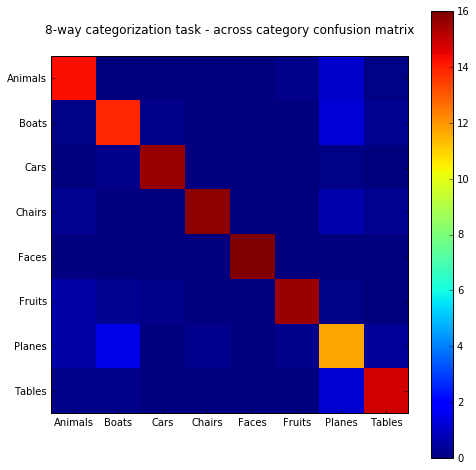

In [10]:
# Confusion matrix
fig = plt.figure(figsize=(8, 8))
m = fig.gca().matshow(np.array(res['result_summary']['cms']).mean(2))
plt.xticks(range(8), res['result_summary']['labelset'])
plt.yticks(range(8), res['result_summary']['labelset'])
plt.colorbar(m)
plt.title('8-way categorization task - across category confusion matrix')
ax = plt.gca()
ax.xaxis.tick_bottom()